In [1]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black
import mixpred
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Data simulation

In [2]:
np.random.seed(42)

n_indiv = 50000
eurprs = np.random.normal(size=n_indiv)
afrprs = np.random.normal(size=n_indiv)
eurprop = np.random.uniform(size=n_indiv)
afrprop = 1 - eurprop
env = np.random.normal(size=n_indiv)

# part 1: (0.8 * eurprs * eurprop + 0.2 * afrprs * afrprop)
# overall 0.8 effects from eurprs, 0.2 effects from afrprs, reflecting sample size / heritability
# contribution varies as a function of proportion of ancestry (eurprop/afrprop)
# part 2: eurprop * 0.1
# effects of ancestry proportion
# part 3: env * 1.0
# environmental effects
y = 0.8 * eurprs * eurprop + 0.2 * afrprs * afrprop + eurprop * 0.1 + env * 1.0

In [3]:
data = pd.DataFrame(
    {
        "EURPRS": eurprs,
        "AFRPRS": afrprs,
        "EURPROP": eurprop,
        "AFRPROP": afrprop,
        "ENV": env,
        "PHENO": y,
    }
)

data.index.name = "indiv"
train_data, test_data = train_test_split(data, test_size=0.5)
# index at first column of data files
train_data.to_csv("train_data.tsv", sep="\t")
test_data.to_csv("test_data.tsv", sep="\t")

# Model estimation and prediction

In [4]:
%%bash
# because EURPROP and AFRPROP are perfectly correlated, we only use EURPROP in mix-cols
python mixpred.py train-cli \
    --df train_data.tsv \
    --y-col PHENO --pred-cols EURPRS,AFRPRS --mix-cols EURPROP --covar-cols EURPROP \
    --out model.pkl

Received parameters: 
train-cli
  --df=train_data.tsv
  --y_col=PHENO
  --pred_cols=('EURPRS', 'AFRPRS')
  --mix_cols=EURPROP
  --out=model.pkl
  --covar_cols=EURPROP
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.182
Model:                            OLS   Adj. R-squared:                  0.182
Method:                 Least Squares   F-statistic:                     1113.
Date:                Fri, 22 Sep 2023   Prob (F-statistic):               0.00
Time:                        12:41:17   Log-Likelihood:                -35485.
No. Observations:               25000   AIC:                         7.098e+04
Df Residuals:                   24994   BIC:                         7.103e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                     coef    std err       

In [5]:
%%bash
python mixpred.py predict-cli \
    --df test_data.tsv \
    --model model.pkl \
    --out test_pred.tsv

Received parameters: 
predict-cli
  --df=test_data.tsv
  --model=model.pkl
  --out=test_pred.tsv
Predictions written to test_pred.tsv


To interpret the model output, we rewrite our simulation equation
```
y = 0.8 * eurprs * eurprop + 0.2 * afrprs * afrprop + eurprop * 0.1 + env * 1.0
```
as
```
y = const * 0 + 
    eurprop * 0.1 + 
    eurprs * (const * 0 + eurprop * 0.8) + 
    afrprs * (const * 0 + afrprop * 0.2) <----> afrprs * (const * 1 + eurprop * -0.2)
```
We can see that it aligns well with the estimation above.

In [6]:
pred_df = pd.read_csv("test_pred.tsv", sep="\t", index_col=0)
test_df = pd.read_csv("test_data.tsv", sep="\t", index_col=0)
test_pred_df = pd.merge(test_df, pred_df, left_index=True, right_index=True)

# Visualization
- We see `EURPRS` has higher overall weights because its simulated large effects. Meanwhile, both `EURPRS` and `AFRPRS` varies across individuals.
- The figure would look prettier when we have `xcol=PC1` and `ycol=PC2`.

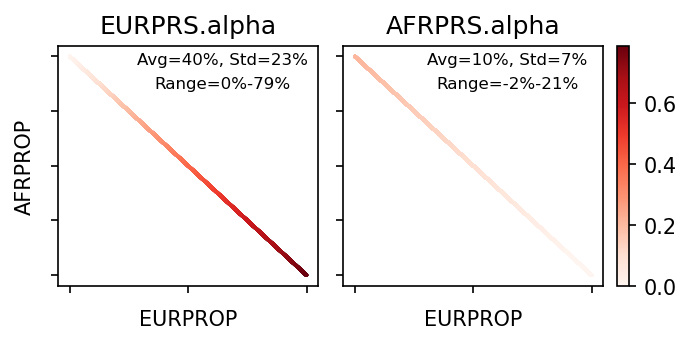

In [7]:
fig, axes = mixpred.plot_alpha(
    test_pred_df,
    alpha_cols=["EURPRS.alpha", "AFRPRS.alpha"],
    xcol="EURPROP",
    ycol="AFRPROP",
    vmin=0,
)